## Objective

#### How much interest will a new rental listing on RentHop receive?

In this <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>, you will predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

### File descriptions

- **```train.json```** - the training set
- **```test.json```** - the test set


### Data fields

- **```bathrooms:```** number of bathrooms
- **```bedrooms:```** number of bathrooms
- **```building_id```**
- **```created```**
- **```description```**
- **```display_address```**
- **```features:```** a list of features about this apartment
- **```latitude```**
- **```listing_id```**
- **```longitude```**
- **```manager_id```**
- **```photos:```** a list of photo links. You are welcome to download the pictures yourselves from renthop's site, but they are the same as imgs.zip. 
- **```price:```** in USD
- **```street_address```**
- **```interest_level:```** this is the target variable. It has 3 categories: 'high', 'medium', 'low'


## Exploratory analysis

In [1]:
from __future__ import print_function, division

In [525]:
# %load pp_tools.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))

def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    
def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)

def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    
def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)

Open listings database

In [526]:
from pymongo import MongoClient

In [527]:
client = MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

KeyboardInterrupt: 

Print one of them.

In [7]:
pp_dict(collection.find_one())

listing_id,6818139
_id,58ac97520b0203c6b6436f4c
display_address,Hausman Street
description,"This one WON'T LAST!! Here is a stunning 3 Bedroom, 2 Full Bathroom apartment measuring approximately 1100 sqft! The layout is NOT a railroad with a King Sized master bedroom complete with on suite full bathroom and bay-windows. The 2nd and 3rd bedrooms can fit a Full or Queen sized bed and have over-sized windows. Thee is a second full bathroom with soaking tub off of the main hallway. Open concept kitchen with large island finished in real stone counters and soft close cabinetry plus Stainless Steel industrial sized appliances! Heated hardwood flooring throughout with tons of sunlight and space. Central HVAC means that you never have to be too hot or too cold again!One of the best locations for street parking in Greenpoint! Don't have a car? No Problem, the Nassau G Train and Grand St L train are within reach.Call, Text, Email Taylor now to schedule your private showing. Not exactly what you are looking for? Email me your search criteria, I Specialize in North Brooklyn!-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice. Miron Properties is a licensed Real Estate Broker. www.MironProperties.com<a website_redacted"
created,2016-04-03 02:22:45
price,2995
bedrooms,3
interest_level,medium
longitude,-73.9389
photos,https://photos.renthop.com/2/6818139_a50e80ff79c71a1ced4ec103985abdd9.jpg https://photos.renthop.com/2/6818139_a2be68c008aeff88347f97dc0350f85d.jpg https://photos.renthop.com/2/6818139_63166d3d69203d7bd63e8e8bb47db8c6.jpg https://photos.renthop.com/2/6818139_1aba230faec5ed91372bb3996b98acf1.jpg https://photos.renthop.com/2/6818139_af28eb103bab59ec9d929c3657d846e6.jpg https://photos.renthop.com/2/6818139_3637c3737c1286332310476fa4d5b1d8.jpg https://photos.renthop.com/2/6818139_83f4bfb1928581fb9feec154629f62e9.jpg
manager_id,198d2e96429920ff71cd06ddff323713


Examine numerical values

In [96]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
c = collection.find({}, {'_id':0, 'interest_level':1, 'bedrooms':1, 'bathrooms':1, 'price':1})
df = pd.DataFrame(list(c))
df.interest_level = df.interest_level.astype('category', categories=['low', 'medium', 'high'])

In [528]:
def pp_counts(series, rows=1):
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)

In [529]:
def percentplot(data, var, title=None, ax=None):
    ax = sns.barplot(x=var, y=var, data=data, estimator=lambda x: len(x) * 100 / len(data))
    ax.set(ylabel="Percent")
    ax.set(xlabel='')
    ax.set(title=var if title is None else title)
    return ax

In [530]:
def categoryplot(data, feature, category='interest_level', ax=None):
    categories = data[category].cat.categories
    n = len(categories)

    space = 0.1
    width = (1.0 - space) / n

    xlabels = None
    for i, cat in enumerate(categories):
        counts = data[data[category] == cat][feature].value_counts().sort_index() / len(data)
        indices = range(len(counts))
        pos = [j - (1.0 - gap) / 2 + i * width for j in indices]
        ax.bar(pos, counts * 100, width=width, label=cat, color=sns.color_palette()[i])
        if i == 0:
            ax.set_xticks(indices)
            ax.set_xticklabels(counts.axes[0])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    ax.set_ylabel('percent')
    return ax

The interest level is heavily skewed to 'low' and 'medium'

high,0.0778,low,0.6947,medium,0.2275


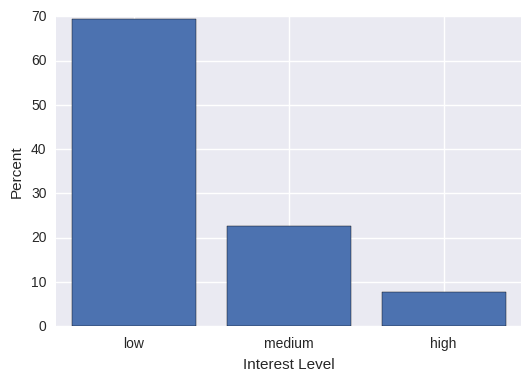

In [531]:
value_counts = df.interest_level.value_counts(normalize=True)
pp_counts(value_counts)
plt.bar(range(3), value_counts * 100, align='center')
plt.xticks(range(3), df.interest_level.cat.categories)
plt.xlabel('Interest Level')
plt.ylabel('Percent');

Eight-percent of the listings are for studios, one- and two-bedrooms. The interest in these is fairly consistent.

0,0.1920,1,0.3192,2,0.2963,3,0.1474,4,0.0391,5,0.0050,6,0.0009,7,0.0000,8,0.0000


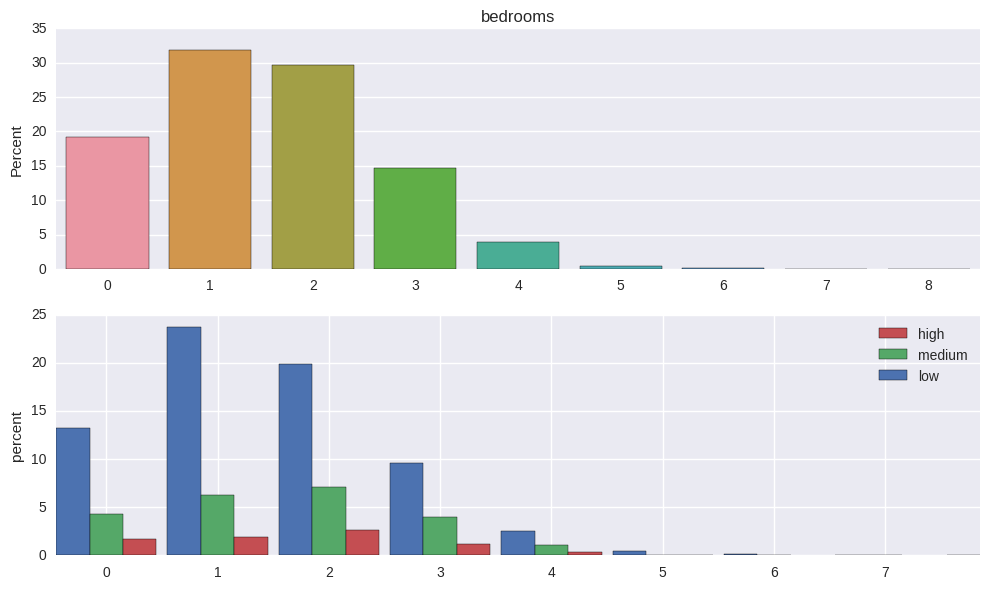

In [532]:
pp_counts(df.bedrooms.value_counts(normalize=True))
fig = plt.figure(figsize=(10, 6))
percentplot(df, 'bedrooms', ax=plt.subplot(211))
categoryplot(df, 'bedrooms', ax=plt.subplot(212));
fig.tight_layout()

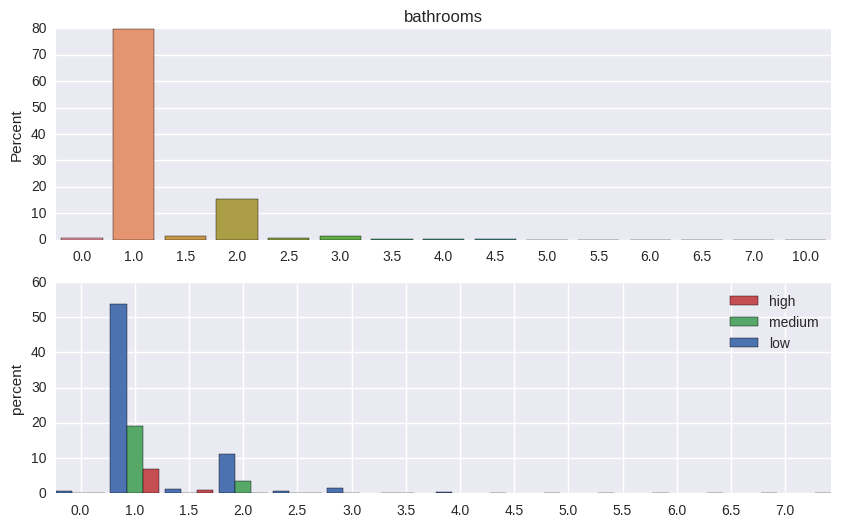

In [533]:
pp_counts(df.bathrooms.value_counts(normalize=True), rows=2)
fig = plt.figure(figsize=(10, 6))
percentplot(df, 'bathrooms', ax=plt.subplot(211))
categoryplot(df, 'bathrooms', ax=plt.subplot(212));

In [534]:
np.max(df.price)

4490000

In [535]:
price_bins=range(0, 10000, 500) + [5e6]
bins = pd.cut(df.price, bins=price_bins)
df['price_bucket'] = bins.apply(lambda x: re.sub('\([0-9]+, ([0-9]+)\]', '\\1', x)).astype(int)

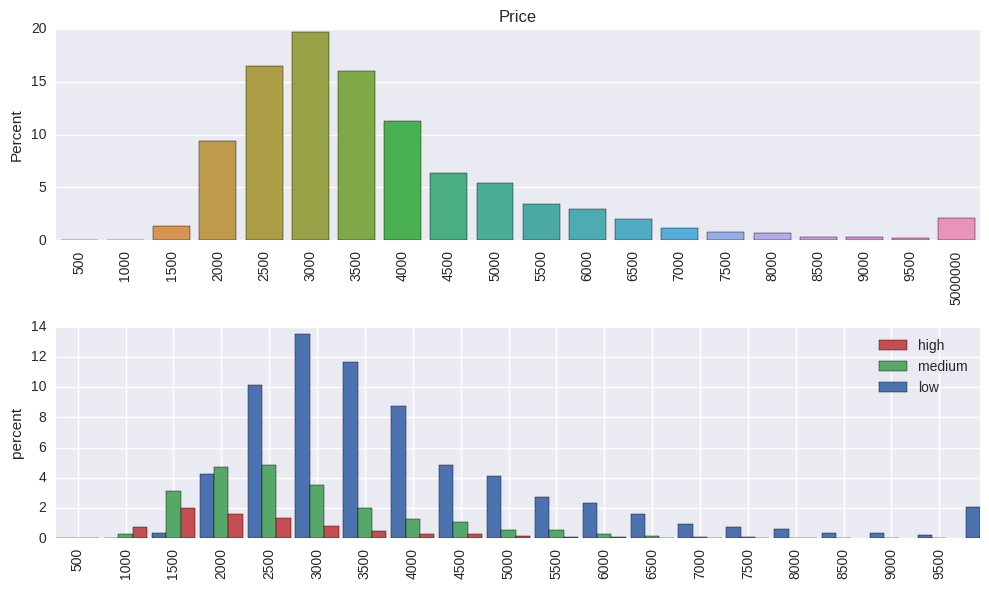

In [536]:
pp_counts(df.price_bucket.value_counts(normalize=True), rows=3)
fig = plt.figure(figsize=(10, 6))
ax = percentplot(df, 'price_bucket', 'Price', ax=plt.subplot(211))
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax = categoryplot(df, 'price_bucket', ax=plt.subplot(212))
for item in ax.get_xticklabels():
    item.set_rotation(90)
fig.tight_layout()

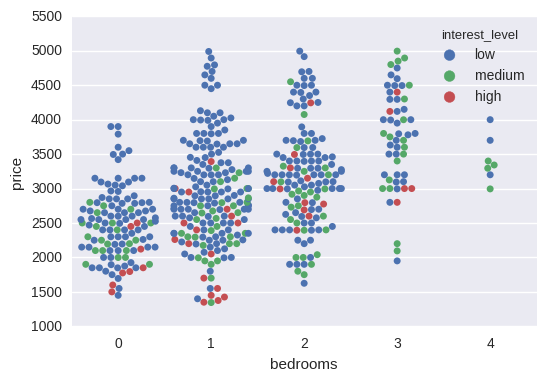

In [523]:
df2 = df[df.price < 5000].copy()
sns.swarmplot(x='bedrooms', y='price', hue='interest_level', data=df2.sample(500));